티스토리 블로그 : https://today-1.tistory.com/41

In [68]:
# data load
import pandas as pd
import numpy as np
from pandas.tseries.offsets import Day, Hour, Minute, Second

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

print('train shape: ', train.shape)
print('test shape: ', test.shape)
train.head()

train shape:  (10886, 12)
test shape:  (6493, 9)


datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [ ]:
# prophet 라이브러리 임포트
# %pip install pystan==2.19.1.1
# %pip install prophet

from prophet import Prophet

# Prophet 시각화 도구
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

In [ ]:
# target 데이터를 ds, y로 전처리
y_train_prophet_df = train[['datetime','count']]
y_train_prophet_df.columns = ['ds', 'y']
y_train_prophet_df.head()

,ds,y
0,2011-01-01 00:00:00,16
1,2011-01-01 01:00:00,40
2,2011-01-01 02:00:00,32
3,2011-01-01 03:00:00,13
4,2011-01-01 04:00:00,1


In [ ]:
# ds, y를 제외한 x 변수들을 따로 df 처리
x_col = [i for i in train.columns if i not in ['datetime','count']]
x_train_prophet_df = train[x_col]
x_train_prophet_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,1,0,0,1,9.84,14.395,81,0.0,3,13
1,1,0,0,1,9.02,13.635,80,0.0,8,32
2,1,0,0,1,9.02,13.635,80,0.0,5,27
3,1,0,0,1,9.84,14.395,75,0.0,3,10
4,1,0,0,1,9.84,14.395,75,0.0,0,1


In [ ]:
# propeht 학습 시에는 꼭 df, y, x 변수 순서대로 쌓인 df를 밀어넣어야 한다.
yx_train_prophet_df = pd.concat([y_train_prophet_df, x_train_prophet_df], axis=1)

In [ ]:
# prophet 모델링 기본
# Prophet Model에 hyper parameter 설명은 아래와 같음
# 크게 5가지로 1) 선형/비선형 선택, 2) 추세, 3) 계절성, 4) 휴일, 5) 기타 등으로 구분됨
# ARIMA, SARIMA 등 통계 기반 모델의 hyper parameter 와는 달리 기술적으로 참고해서 입력할 수 있는 para가 거의 없음
# 실제 현업을 잘 이해하고 있는 전문가들이 예측하고자 하는 문제와 관련된 이벤트, 민감도 외 기타 등등 핸들링이 용이함

fit_default_prophet = Prophet(
    # linear, nonlinear
    growth='linear',

    # Trend (추세)
    changepoints=None,              # CP가 발생하는 시점들의 list
    n_changepoints=25,              # CP의 수
    changepoint_range=0.8,          # CP의 기존 데이터 수 대비 최대 비율
    changepoint_prior_scale=0.05,   # CP 추정 민감도로 높을수록 민감

    # Seasonality
    seasonality_mode='additive',    # 계절성 모델 : 'additive' or 'multiplicative'
    seasonality_prior_scale=10.0,   # 계절성 추정 민감도로 높을수록 민감
    yearly_seasonality='auto',      # 연계절성
    weekly_seasonality='auto',      # 월계절성
    daily_seasonality='auto',       # 일계절성

    # Holiday
    holidays=None,                  # 휴일 또는 이벤트 시점
    holidays_prior_scale=10.0,      # 휴일 추정 민감도로 높을수록 민감

    # Others
    interval_width=0.8,             # 추세 예측 정확도 구간 범위
    mcmc_samples=0,                 # 계절성 예측 정확도 제어
)

In [ ]:
# model 학습
fit_reg1_prophet = fit_default_prophet.fit(yx_train_prophet_df)

sub=pd.read_csv('sampleSubmission.csv')

# Frequency에 대한 사전 df를 만듦
forecast = fit_reg1_prophet.make_future_dataframe(freq='H', periods=sub.shape[0])

pred_reg1_prophet = fit_reg1_prophet.predict(forecast)
pred_train_reg1_prophet = np.ravel(pred_reg1_prophet.loc[:yx_train_prophet_df.shape[0]-1, ['yhat']])
pred_test_reg1_prophet = np.ravel(pred_reg1_prophet.loc[yx_train_prophet_df.shape[0]:, ['yhat']])
pd.DataFrame(pred_test_reg1_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -289.084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18055.4   0.000441601       107.856      0.4973      0.4973      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18067.5     0.0025606       325.923           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       18072.5   0.000118406       154.248   9.681e-07       0.001      410  LS failed, Hessian reset 
     299       18072.8   0.000961324       108.414      0.8137      0.8137      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       18073.7   7.56445e-05       103.874   5.482e-07       0.001      547  LS failed, Hessian reset 
     399       18074.3   0.000402797       80.3412      0.3065           1      579   
    Iter      log pro

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,0
0,113.272475
1,95.719479
2,52.502323
3,11.924392
4,14.029292
...,...
6488,141.209227
6489,139.351736
6490,118.898111
6491,104.287083


In [ ]:
sub['count'] = pred_test_reg1_prophet
sub['count'] = sub['count'].apply(lambda x:round(x,0))
sub.loc[sub['count']<0,'count'] = 0
sub.head()

,datetime,count
0,2011-01-20 00:00:00,113.0
1,2011-01-20 01:00:00,96.0
2,2011-01-20 02:00:00,53.0
3,2011-01-20 03:00:00,12.0
4,2011-01-20 04:00:00,14.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


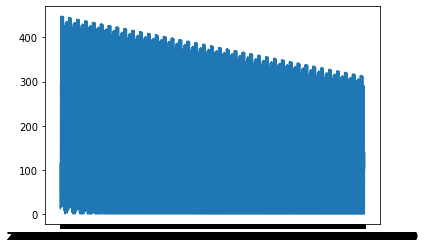

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sub['datetime'], sub['count'])
plt.show()